In [1]:
# These two lines ensure that we always import the latest version of a package, in case it has been modified.
%load_ext autoreload
%autoreload 2

import timm
import torch
import detectors
from torchvision import transforms
from utils import vis as vis

/home/kvergopoulos/miniconda3/envs/ffcv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import os
from tqdm import tqdm

from data_utils.data_stats import *
from models.networks import get_model
from data_utils.dataloader import get_loader
from data_utils.dataset_to_beton import get_dataset

In [3]:
# define important parameters

dataset         = 'cifar10'               # One of cifar10, cifar100, stl10, imagenet or imagenet21
num_classes     = CLASS_DICT[dataset]
data_path       = '/scratch/ffcv'
model_path      = '/tmp/zooming_in_on_mlps/'
eval_batch_size = 32
crop_resolution = 32
data_resolution = 32 
checkpoint      = None
device          = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model_type      = 'mlp'                   
checkpoint      = 'in21k_cifar10'       
architecture    = 'B_12-Wi_1024'        
crop_resolution = 64   

In [4]:
def get_models_full(model_type, 
                    architecture, 
                    resolution  = crop_resolution, 
                    num_classes = CLASS_DICT[dataset], 
                    checkpoint  = checkpoint, 
                    model_path   = model_path):
    if model_type == 'mlp':
        model = get_model(architecture=architecture, resolution = resolution, 
                          num_classes=num_classes,checkpoint= checkpoint)
        model = torch.nn.Sequential(vis.Reshape(64), model)
    elif model_type == 'cnn':
        model = timm.create_model(architecture, pretrained=True)
    elif model_type == 'vit':
        model = torch.load(os.path.join(model_path, architecture))
        model = torch.nn.Sequential(vis.Reshape(224), model)
    return model

Weights already downloaded
Load_state output <All keys matched successfully>
Loading /scratch/ffcv/cifar10/val_32.beton


/home/kvergopoulos/miniconda3/envs/ffcv/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


probability for target class 0.4835677742958069
all probabilities tensor([0.0396, 0.1941, 0.0328, 0.0406, 0.0474, 0.0417, 0.0387, 0.0432, 0.4836,
        0.0382], grad_fn=<SoftmaxBackward0>)
probability for target class 0.6053304672241211
all probabilities tensor([0.0388, 0.0725, 0.0367, 0.0436, 0.0441, 0.0413, 0.0390, 0.0424, 0.6053,
        0.0361], grad_fn=<SoftmaxBackward0>)
probability for target class 0.6257598996162415
all probabilities tensor([0.0376, 0.0604, 0.0361, 0.0429, 0.0424, 0.0401, 0.0383, 0.0413, 0.6258,
        0.0350], grad_fn=<SoftmaxBackward0>)
probability for target class 0.6375758051872253
all probabilities tensor([0.0367, 0.0553, 0.0353, 0.0422, 0.0412, 0.0393, 0.0376, 0.0406, 0.6376,
        0.0342], grad_fn=<SoftmaxBackward0>)
probability for target class 0.6462640166282654
all probabilities tensor([0.0359, 0.0522, 0.0346, 0.0415, 0.0403, 0.0386, 0.0371, 0.0399, 0.6463,
        0.0336], grad_fn=<SoftmaxBackward0>)
probability for target class 0.65338611602783

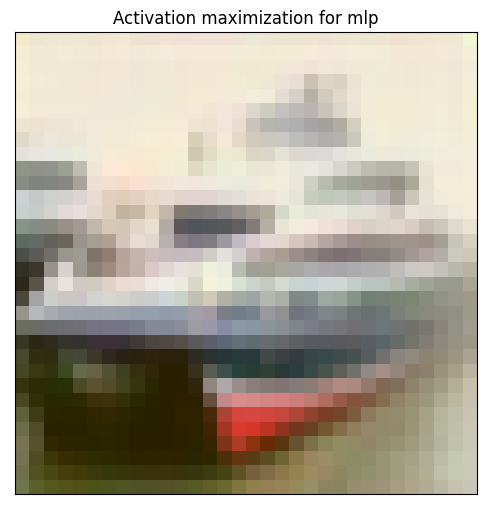

In [7]:
model_type      = 'mlp'                   
checkpoint      = 'in21k_cifar10'       
architecture    = 'B_12-Wi_1024'        
crop_resolution = 32 

# load the models
torch.backends.cuda.matmul.allow_tf32 = True
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = get_models_full(model_type, architecture)
model.to(device)
with torch.no_grad():
    model.eval()

loader = get_loader(
        dataset,
        bs=eval_batch_size,
        mode="test",
        augment=False,
        dev=device,
        mixup=0.0,
        data_path=data_path,
        data_resolution=data_resolution,
        crop_resolution=crop_resolution,
    )

# for activation maximization. Start from total random noise or use
# an initial image instead
use_init_image = True

# generate image using activation maximization
dataiter    = iter(loader)
ims, labels = next(dataiter)
img         = ims[1].unsqueeze(0)
label       = labels[1]

if use_init_image == False:
    img   = None
    label = 0
else:
    label = label.item()

init_image1, synthetic_image1 = vis.generate_image(model        = model, 
                                     target_class = label,
                                     epochs       = 250, 
                                     min_prob     = 0.9, 
                                     lr           = .01, 
                                     weight_decay = 5e-2, 
                                     step_size    = 100, 
                                     gamma        = 0.9,
                                     noise_size   = crop_resolution,
                                     model_type   = model_type,
                                     img          = img,
                                     dataset      = dataset)


Loading /scratch/ffcv/cifar10/val_32.beton
probability for target class 0.9999675750732422


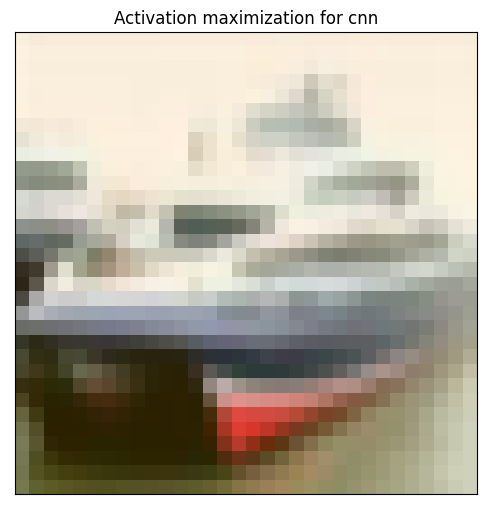

In [115]:
model_type      = 'cnn'               
architecture    = 'resnet18_' + dataset                      
crop_resolution = 32 

# load the model
torch.backends.cuda.matmul.allow_tf32 = True
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = get_models_full(model_type, architecture)
model.to(device)
with torch.no_grad():
    model.eval()

# initialize loader
loader = get_loader(
        dataset,
        bs=eval_batch_size,
        mode="test",
        augment=False,
        dev=device,
        mixup=0.0,
        data_path=data_path,
        data_resolution=data_resolution,
        crop_resolution=crop_resolution,
    )

# for activation maximization. Start from total random noise or use
# an initial image instead
use_init_image = True

# generate image using activation maximization
dataiter    = iter(loader)
ims, labels = next(dataiter)
img         = ims[1].unsqueeze(0)
label       = labels[1]

if use_init_image == False:
    img   = None
    label = 0
else:
    label = label.item()

init_image2, synthetic_image2 = vis.generate_image(model        = model, 
                                     target_class = label,
                                     epochs       = 250, 
                                     min_prob     = 0.9, 
                                     lr           = .01, 
                                     weight_decay = 5e-2, 
                                     step_size    = 100, 
                                     gamma        = 0.9,
                                     noise_size   = crop_resolution,
                                     model_type   = model_type,
                                     img          = img,
                                     dataset      = dataset)

Loading /scratch/ffcv/cifar10/val_32.beton
probability for target class 0.7589551210403442
probability for target class 0.902209460735321
probability for target class 0.9396027326583862
probability for target class 0.9532944560050964


/home/kvergopoulos/miniconda3/envs/ffcv/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


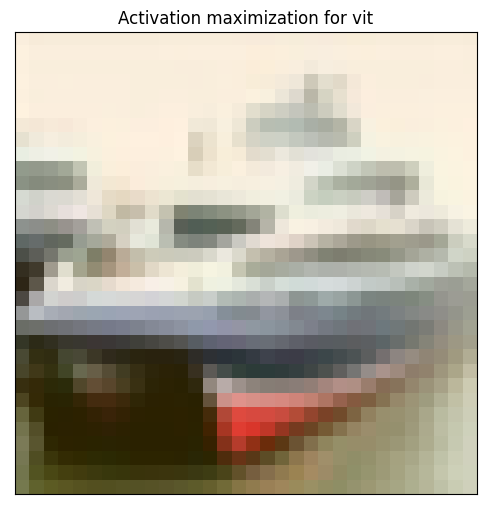

In [116]:
model_type      = 'vit'                  
architecture    = 'vit_small_patch16_224_' + dataset + '_v7.pth'        
crop_resolution = 224 

# load the model
torch.backends.cuda.matmul.allow_tf32 = True
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = get_models_full(model_type, architecture)
model.to(device)
with torch.no_grad():
    model.eval()

# initialize loader
loader = get_loader(
        dataset,
        bs=eval_batch_size,
        mode="test",
        augment=False,
        dev=device,
        mixup=0.0,
        data_path=data_path,
        data_resolution=data_resolution,
        crop_resolution=crop_resolution,
    )

# for activation maximization. Start from total random noise or use
# an initial image instead
use_init_image = True

# generate image using activation maximization
dataiter    = iter(loader)
ims, labels = next(dataiter)
img         = ims[1].unsqueeze(0)
label       = labels[1]

if use_init_image == False:
    img   = None
    label = 0
else:
    label = label.item()

init_image3, synthetic_image3 = vis.generate_image(model        = model, 
                                     target_class = label,
                                     epochs       = 150, 
                                     min_prob     = 0.9, 
                                     lr           = .01, 
                                     weight_decay = 5e-2, 
                                     step_size    = 100, 
                                     gamma        = 0.9,
                                     noise_size   = crop_resolution,
                                     model_type   = model_type,
                                     img          = img,
                                     dataset      = dataset)

In [117]:
print(f'norm original image mlp {torch.norm(init_image1 - synthetic_image1)}')
print(f'norm original image cnn {torch.norm(init_image2 - synthetic_image2)}')
print(f'norm original image vit {torch.norm(init_image3 - synthetic_image3)}')

norm original image mlp 0.705284059047699
norm original image mlp 0.0
norm original image mlp 0.08486096560955048


In [51]:
#model_type      = 'vit'                  
#architecture    = 'vit_small_patch16_224_' + dataset + '_v7.pth'        
#crop_resolution = 32 

#model_type      = 'cnn'               
#architecture    = 'resnet18_' + dataset                      
#crop_resolution = 32 

model_type      = 'mlp'                   
checkpoint      = 'in21k_cifar10'       
architecture    = 'B_12-Wi_1024'        
crop_resolution = 32 

# load the model
torch.backends.cuda.matmul.allow_tf32 = True
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = get_models_full(model_type, architecture)
model.to(device)
with torch.no_grad():
    model.eval()

# initialize loader
loader = get_loader(
        dataset,
        bs=eval_batch_size,
        mode="test",
        augment=False,
        dev=device,
        mixup=0.0,
        data_path=data_path,
        data_resolution=data_resolution,
        crop_resolution=crop_resolution,
    )

Weights already downloaded
Load_state output <All keys matched successfully>
Loading /scratch/ffcv/cifar10/val_32.beton


In [54]:
if model_type == 'cnn':
    modules = ['conv1', 'layer1.0.conv1']
    
if model_type == 'vit':
    modules = ['1.blocks.0.mlp.fc1', '1.blocks.1.mlp.fc1']

if model_type == 'mlp':
    modules = ['1.blocks.0.block.0', '1.blocks.2.block.0']

In [55]:
dataiter    = iter(loader)
ims, labels = next(dataiter)
img         = ims[1].unsqueeze(0)
label       = labels[1]

Linear(in_features=1024, out_features=4096, bias=True)


/home/kvergopoulos/miniconda3/envs/ffcv/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


0.0055639720521867275
0.0034382829908281565
0.0033695208840072155
0.0033074934035539627
0.0032501069363206625
0.0031960688065737486
0.0031445161439478397
0.0030949003994464874
0.0030468327458947897
0.003000053111463785
0.0029544320423156023
0.002909927163273096
0.002866314025595784
0.0028235716745257378
0.0027816379442811012
0.0027406122535467148
0.002700402867048979
0.002660934114828706
0.002622270490974188
0.0025843472685664892
0.0025471036788076162
0.0025105313397943974
0.002474620472639799
0.002439410425722599
0.0024049035273492336
0.002371030393987894
0.0023378413170576096
0.0023053584154695272
0.0022735740058124065
0.002242427784949541
0.002211854327470064
0.0021818990353494883
0.002152499742805958
0.0021236443426460028
0.002095339121297002
0.0020675675477832556
0.0020403119269758463
0.002013561548665166
0.0019873410928994417
0.0019616277422755957
0.0019363904139027
0.0019339034333825111
0.0019314208766445518
0.0019289421616122127
0.0019264690345153213
0.0019240000983700156
0.001

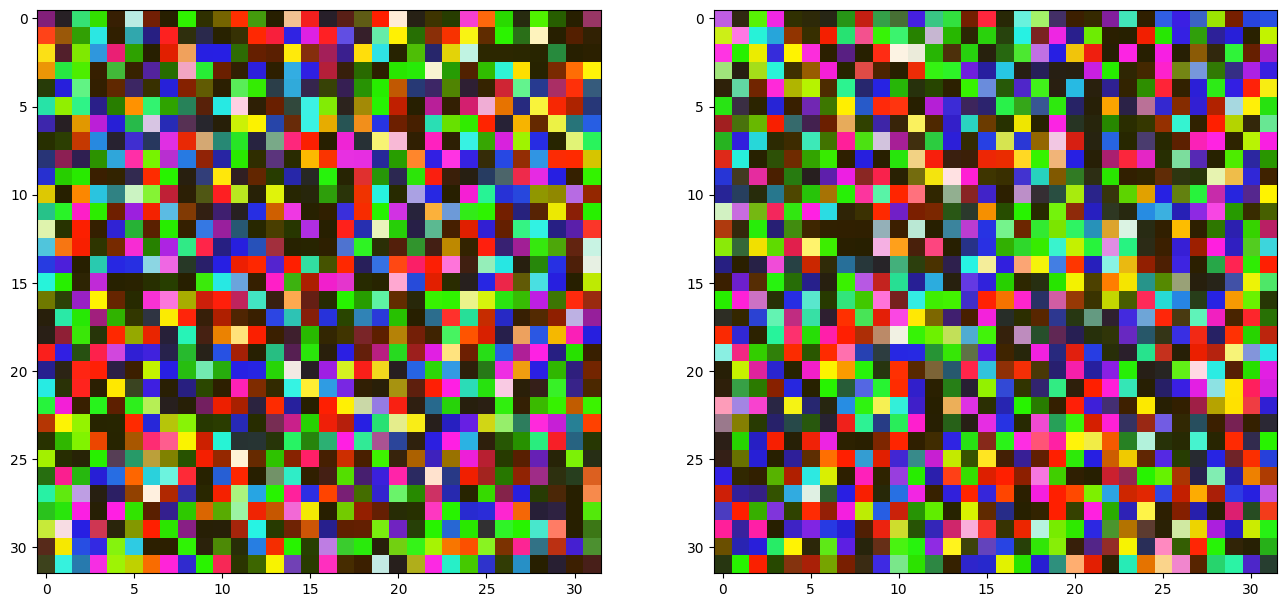

In [56]:
vis.feature_inversion(model         = model, 
                      modules_names = modules, 
                      img           = img,
                      noise_size    = crop_resolution,
                      epochs        = 150, 
                      lr            = 1000,
                      step_size     = 100,
                      gamma         = 0.6,
                      mu            = 1e-1,
                      device        = device)